In [9]:
import os
import numpy as np
from tifffile import imread
import pandas as pd
import cv2
import warnings
warnings.filterwarnings("ignore")

input_dir = "/media/ocb/OCB-Data2/PhotoFiTT/TRACKING-UNSYNC"
output_dir = "/home/ocb/HardDrive_4TB/EGM/PHX/ANALYSIS/UNSYNCHRO/TRACKING"
os.makedirs(output_dir, exist_ok=True)


In [2]:
def extract_tracking_from_file(path2file, frame_rate=1):
    V = imread(path2file)
    V = np.squeeze(V)
    # Make sure that frames are in the first dimension
    if V.shape[0] != np.min(V.shape):
        V = np.transpose(V, axis=[-1, 0,1])
    tracks = np.unique(V)
    # Ensure the track list is not empty
    data = None
    if len(tracks) > 1:
        # Remove the label=0 (background) from the list
        tracks = tracks[1:] #
        for t in tracks:
            index_t = np.where(V == t)[0]
            t0 = np.min(index_t)
            tend = np.max(index_t)
            # Inspect for divisions
            analysis = cv2.connectedComponentsWithStats(np.int8(V[tend]==t))
            if analysis[0] > 2: 
                # there are two points representing the division
                # (labels = background and connected components)
                division = True
                division_t = tend
                tend -= 1
            else:
                division = False
                division_t = -1
            
            mitosis_time = tend-t0
            aux = pd.DataFrame(data =[[t, 
                                       t0*frame_rate, 
                                       tend*frame_rate, 
                                       division, 
                                       division_t*frame_rate, 
                                       mitosis_time*frame_rate]],
                               columns=["ID", 
                                        "Initial t", 
                                        "Final t", 
                                        "Division", 
                                        "Division timepoint", 
                                        "Mitosis duration"])
            # update dataframe
            if data is None:
                data = aux
            else:
                data = pd.concat([data, aux]).reset_index(drop=True)
    return data
            

    
def read_tracking(input_dir, data=None, column_data=[], frame_rate = 4):
    folders = [f for f in os.listdir(input_dir) if not f.startswith(".")]
    folders = [f for f in folders if f!="labeling"]
    for f in folders:
        print(f)
        if f.endswith(".tif"):
            tracking_data = extract_tracking_from_file(os.path.join(input_dir,f), frame_rate = frame_rate)
            for i in range(len(column_data)):
                tracking_data["Subcategory-{:02d}".format(i)] = column_data[i]
            tracking_data["video_name"] = f.split('.tif')[0]
            if data is None:
                data = tracking_data
            else:
                data = pd.concat([data, tracking_data]).reset_index(drop=True)

        else:
            data = read_tracking(os.path.join(input_dir,f), data=data, column_data=column_data + [f])
    return data
            
        

In [3]:
#data = read_tracking(input_dir, frame_rate = 4)
#data = data.drop(columns=["Subcategory-01"])
#data.to_csv(os.path.join(output_dir, "manual_mitosis_counting.csv"))
data = pd.read_csv(os.path.join(output_dir, "manual_mitosis_counting.csv"))

In [5]:
import os
path2data = "/home/ocb/HardDrive_4TB/EGM/PHX/DATA/DOWNSAMPLE/CHO-UNSYNCH/"
new_data = None
for f in np.unique(data["Subcategory-00"]):
    data_f = data.loc[lambda data:data["Subcategory-00"]==f]
    cat = [i for i in os.listdir(os.path.join(path2data, f)) if not i.startswith(".")]
    data_f.loc[:, ["Subcategory-01"]] = cat[0]
    data_f.loc[:, ["Subcategory-02"]] = np.nan
    for k in np.unique(data_f["video_name"]):
        data_v = data_f.loc[lambda data_f:data_f["Subcategory-00"]==f]
        cat_1 = [i for i in os.listdir(os.path.join(path2data, f, cat[0])) if not i.startswith(".")]
        for c in cat_1:
            videos = [i for i in os.listdir(os.path.join(path2data, f, cat[0], c)) if i==f"{k}.tif"]
            if len(videos)>0:
                ind = data_f[data_f["video_name"]==k].index.tolist()
                data_f.loc[ind, ["Subcategory-02"]] = c
    if new_data is None:
        new_data = data_f
    else:
        new_data = pd.concat([new_data,data_f])

/tmp/ipykernel_73804/544812409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f.loc[:, ["Subcategory-01"]] = cat[0]
/tmp/ipykernel_73804/544812409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f.loc[:, ["Subcategory-02"]] = np.nan
/tmp/ipykernel_73804/544812409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

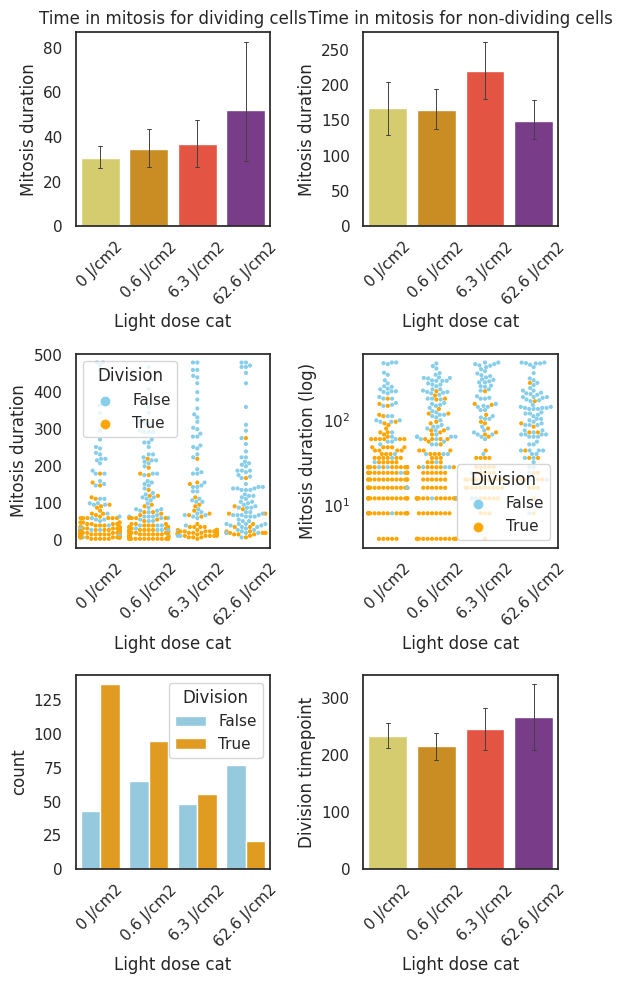

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import photofitt

# name = f"{x}.{f}"# name we want to give to the plot
# new_name = f"barplot_all_{name}"

hue_order = ['0 J/cm2', '0.6 J/cm2', '6.3 J/cm2', '62.6 J/cm2']
pal = ['cornflowerblue', 'orange']
pal = ['orange', 'olivedrab']
pal = ['skyblue', 'orange']
# Estimate the ligth dose
light_power = 6.255662 # fixed power value according to our microscope
new_data = photofitt.utils.numerical_dose(new_data, column_name="Subcategory-02", power=light_power)
new_data = photofitt.utils.power_conversion(new_data, dose_column="Light dose", condition_col="Subcategory-02", condition_name='control-00ms')

fig = plt.figure(figsize=(6, 10))
sns.set(font_scale=0.9)
sns.set_theme(style="white")
plt.subplot(3,2,1)
g = sns.barplot(
    new_data[new_data["Division"]==True],  x='Light dose cat', y="Mitosis duration",
    palette=sns.color_palette("CMRmap_r", 5),
    order=hue_order, errorbar=("ci", 95), capsize=.08, errwidth=0.7
)
plt.tight_layout()
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.title("Time in mitosis for dividing cells")

#--
plt.subplot(3,2,2)
g = sns.barplot(
    new_data[new_data["Division"]==False],  x='Light dose cat', y="Mitosis duration",
    palette=sns.color_palette("CMRmap_r", 5),
    order=hue_order, errorbar=("ci", 95), capsize=.08, errwidth=0.7
)
plt.tight_layout()
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.title("Time in mitosis for non-dividing cells")
#--
plt.subplot(3,2,3)
# Draw a categorical scatterplot to show each observation
g = sns.swarmplot(data=new_data, x='Light dose cat', y="Mitosis duration",
                   hue="Division", palette=pal, order=hue_order, size=3,  linewidth=0)
plt.tight_layout()
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)

#--
plt.subplot(3,2,4)

# Draw a categorical scatterplot to show each observation
g = sns.swarmplot(data=new_data, x='Light dose cat', y="Mitosis duration",
                   hue="Division", palette=pal, order=hue_order, size=3,  linewidth=0)
plt.tight_layout()
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.yscale('log')
g.set(ylabel="Mitosis duration (log)")
#--
plt.subplot(3,2,5)

g=sns.countplot(new_data, x='Light dose cat', hue="Division",
                palette=pal, order=hue_order, )
plt.tight_layout()
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)

plt.subplot(3,2,6)
g = sns.barplot(
    new_data[new_data["Division"]==True],  x='Light dose cat', y="Division timepoint",
    palette=sns.color_palette("CMRmap_r", 5),
    order=hue_order, errorbar=("ci", 95), capsize=.08, errwidth=0.7
)
plt.tight_layout()
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
fig.savefig(os.path.join(output_dir, "mitoses_delays.pdf"), format="pdf", transparent=True)
fig.savefig(os.path.join(output_dir, "mitoses_delays.png"), format="png", transparent=True)
plt.show()


In [205]:
new_data.to_csv(os.path.join(output_dir, "manual_mitosis_counting_categories.csv"))